In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [5]:
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


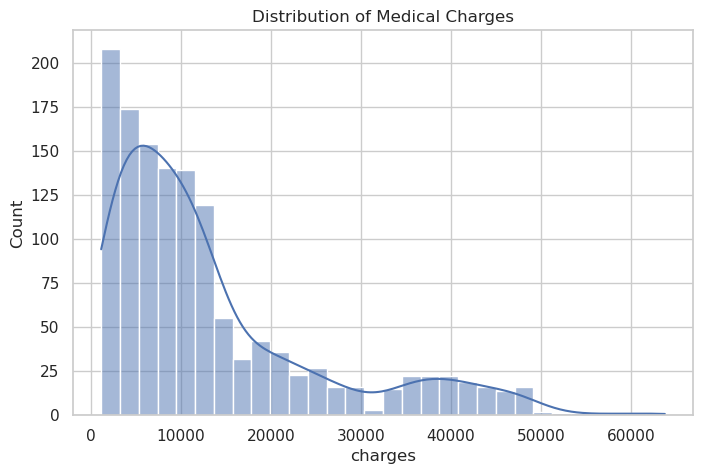

In [8]:
sns.histplot(df["charges"], kde=True)
plt.title("Distribution of Medical Charges")
plt.show()

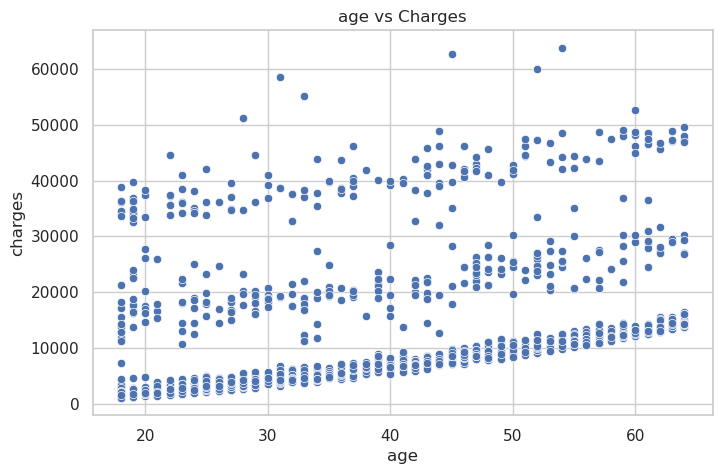

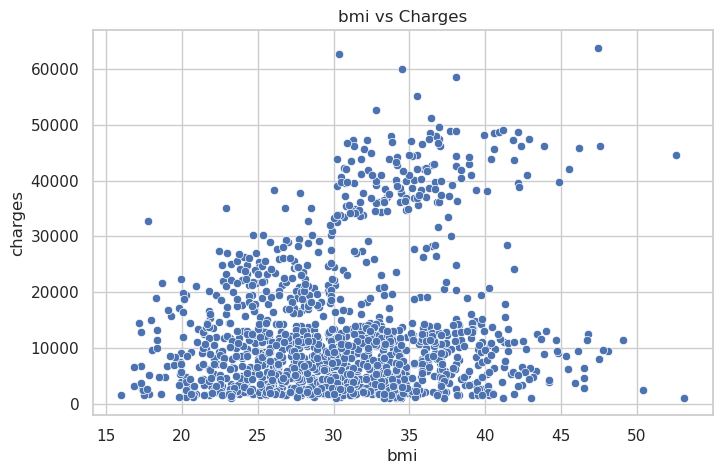

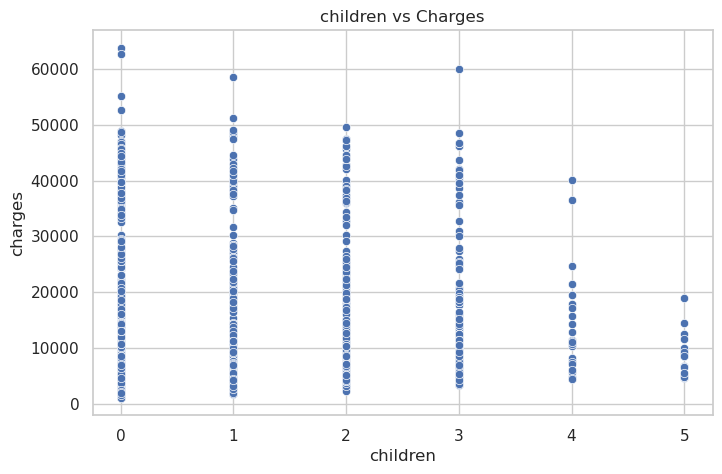

In [9]:
num_features = ["age", "bmi", "children"]

for col in num_features:
    sns.scatterplot(x=df[col], y=df["charges"])
    plt.title(f"{col} vs Charges")
    plt.show()

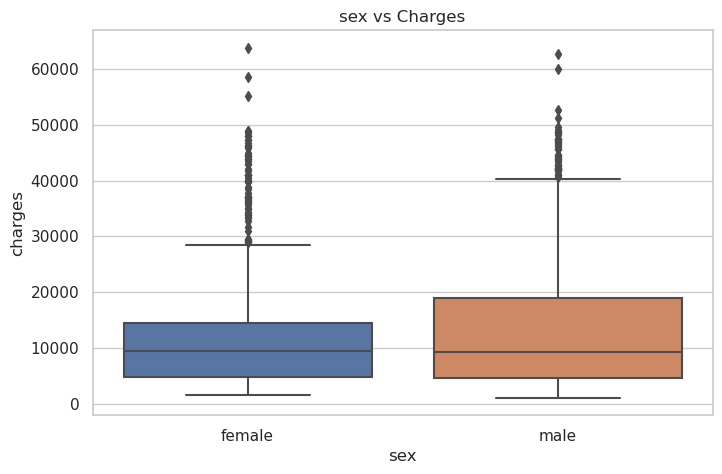

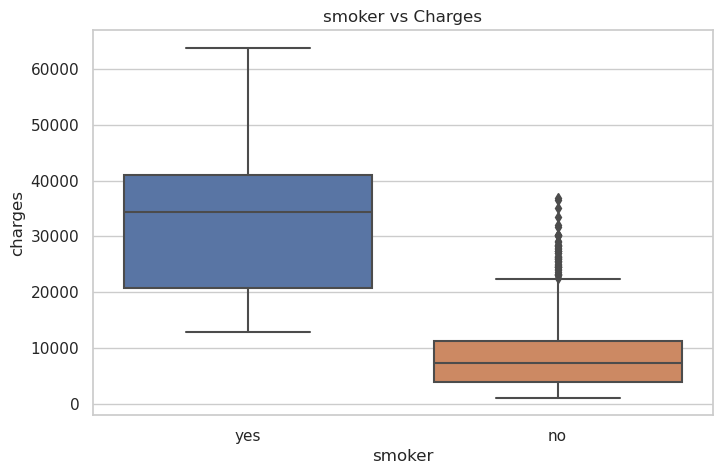

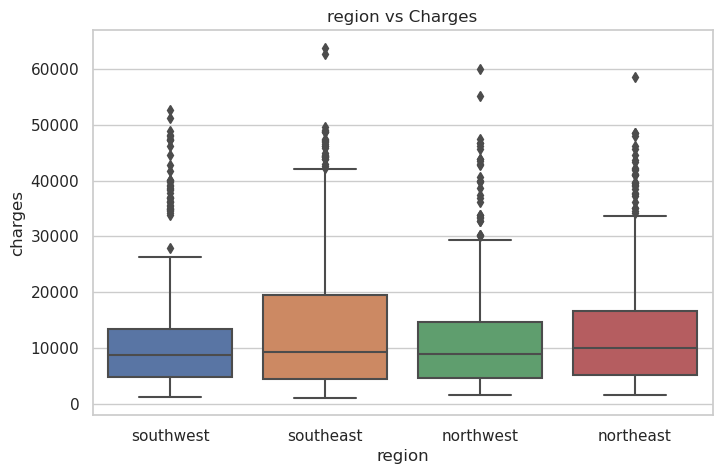

In [10]:
cat_features = ["sex", "smoker", "region"]

for col in cat_features:
    sns.boxplot(x=df[col], y=df["charges"])
    plt.title(f"{col} vs Charges")
    plt.show()

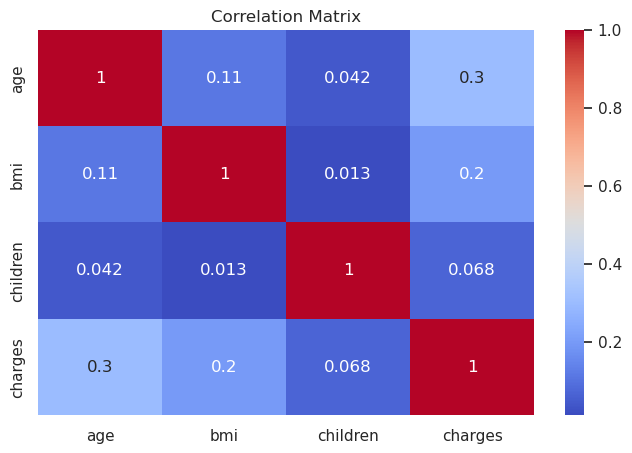

In [11]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [12]:
df["log_charges"] = np.log(df["charges"])
X = df.drop(["charges", "log_charges"], axis=1)
y = df["log_charges"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
num_features = ["age", "bmi", "children"]
cat_features = ["sex", "smoker", "region"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first"), cat_features)
    ]
)

In [14]:
lin_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]
)

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.26969163500404686
RMSE: 0.4190157084978042
R²: 0.8047311493462983


In [15]:
dt = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", DecisionTreeRegressor(max_depth=5, random_state=42))
    ]
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree R²:", r2_score(y_test, y_pred_dt))

Decision Tree R²: 0.8468972101533295


In [16]:
rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=8,
            random_state=42
        ))
    ]
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest R²: 0.85497840272853


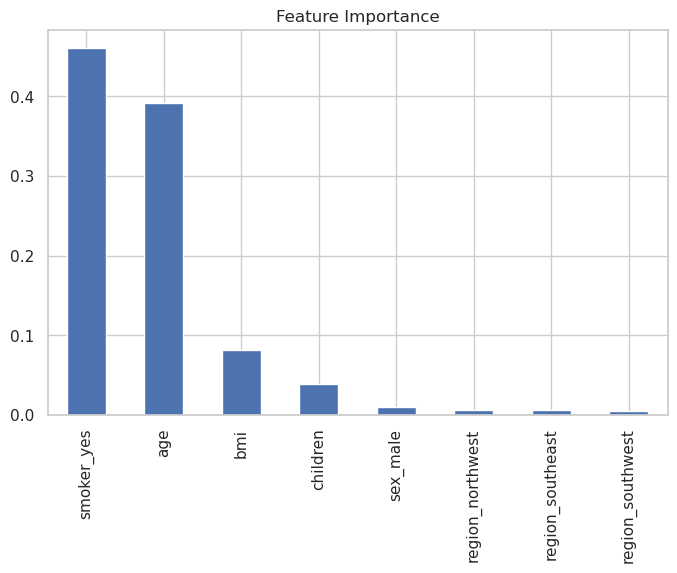

In [17]:
feature_names = (
    num_features +
    list(rf.named_steps["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(cat_features))
)

importances = rf.named_steps["model"].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_imp.plot(kind="bar")
plt.title("Feature Importance")
plt.show()

In [18]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "R2": [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_dt),
        r2_score(y_test, y_pred_rf)
    ]
})

results

,Model,R2
0,Linear Regression,0.804731
1,Decision Tree,0.846897
2,Random Forest,0.854978
